We represent single frames as scalars, according to the correlation between pixel luminance and the target letter. These values are positive when a target is present, and negative when it is absent. When a target is present, but not when it is absent, correlation values are closer to zero when more of the display is occluded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import rv_discrete
from scipy.stats import gaussian_kde
import imageio
import random
from os import path as path
from itertools import islice


In [130]:
biases = {0:0.01,1:0.1}
scalings = [1,0.85,0.7,0.5]

def sample_evidence(present,scaling):
    return bernoulli(biases[present]*scaling).rvs()

def log_likelihood_ratio(sample,scaling):
    if sample==1:
        return np.log((biases[1]*scaling)/(biases[0]*scaling))
    else:
        return np.log((1-(biases[1]*scaling))/(1-(biases[0]*scaling)))

LLRs={(key,scaling):log_likelihood_ratio(key,scaling) for key,value in biases.items() for scaling in scalings}

In [131]:
LLRs

{(0, 1): -0.09531017980432477,
 (0, 0.85): -0.08029488268432933,
 (0, 0.7): -0.06554607789787088,
 (0, 0.5): -0.04628075256400634,
 (1, 1): 2.302585092994046,
 (1, 0.85): 2.302585092994046,
 (1, 0.7): 2.302585092994046,
 (1, 0.5): 2.302585092994046}

In this version, agents commit to a decision when the expected utility from making a decision is higher than the expected utility from continuing to the next timepoint. First, we extract the expected utility per timepoint and evidence value, if participants are committing to a decision. 

In [133]:
frame_cost = 0

dx = 0.01
considered_range = list(np.arange(-2,2,dx))

pcorrect_df = pd.DataFrame(columns=['LLR','posterior_present','posterior_absent',
                                    'pcorrect','utility'])
num_frames = 100

for LLR in considered_range:
    posterior_present = np.exp(LLR)/(1+np.exp(LLR))
    posterior_absent = 1-posterior_present
    pcorrect = max(posterior_present,posterior_absent)
    utility = pcorrect
    pcorrect_df.loc[len(pcorrect_df)] = [LLR,
                        posterior_present,
                        posterior_absent,
                        pcorrect,
                        utility]

frames = []  

for scaling in scalings:
    for i in range(num_frames):
        temp_df = pcorrect_df.copy()  # Make a copy of your DataFrame
        temp_df['scaling'] = scaling  # Create the 'frame' column with the repetition number
        temp_df['frame'] = i  # Create the 'frame' column with the repetition number
        frames.append(temp_df)  # Append the modified DataFrame to the list

# Concatenate all DataFrames in the list
pcorrect_df = pd.concat(frames, ignore_index=True)

In [134]:
temporal_discounting = 0.99


def compute_future_utility(row):
    
    ppresent = row['posterior_present']
    pabsent = row['posterior_absent']
    scaling = row['scaling']
    frame = row['frame']
    LLR = row['LLR']
    
    # probability of evidence values in the next frames
    expected_LLR = np.zeros(len(considered_range))
    
    fail_LLR = LLR + LLRs[(0,scaling)]
    index_of_closest = np.argmin(np.abs(np.array(considered_range) - fail_LLR))
    expected_LLR[index_of_closest] = ppresent*(1-biases[1]*scaling)+pabsent*(1-biases[0]*scaling)

    success_LLR = LLR + LLRs[(1,scaling)]
    index_of_closest = np.argmin(np.abs(np.array(considered_range) - success_LLR))
    expected_LLR[index_of_closest] = ppresent*biases[1]*scaling+pabsent*biases[0]*scaling
    
    next_utility_values = pcorrect_df[(pcorrect_df['frame']==frame+1) & (pcorrect_df['scaling']==scaling)]['updated_utility']

    return(temporal_discounting*(np.nansum(expected_LLR*next_utility_values)+(1-np.nansum(expected_LLR)))+frame_cost)

In [135]:
pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'updated_utility'] = pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'utility']
pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'stop_decision'] = 1

for frame in reversed(range(num_frames-1)):
    print(frame)
    current_frame_df = pcorrect_df[pcorrect_df['frame'] == frame]

    for index, row in current_frame_df.iterrows():
        current_utility = row['utility']

        expected_future_utility = compute_future_utility(row)

        stop_decision=1 if current_utility > expected_future_utility else 0

        updated_utility = max(current_utility, expected_future_utility)

        pcorrect_df.at[index, 'stop_decision'] = stop_decision
        pcorrect_df.at[index, 'updated_utility'] = updated_utility

98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


C:\Users\tanzor\AppData\Local\Temp/ipykernel_19960/1208361059.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df.pivot("LLR", "frame","stop_decision")


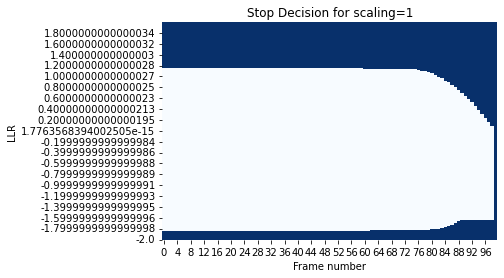

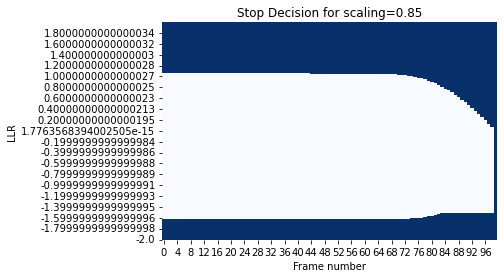

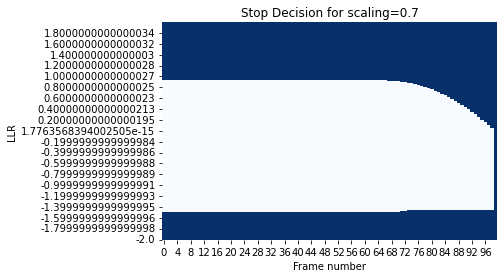

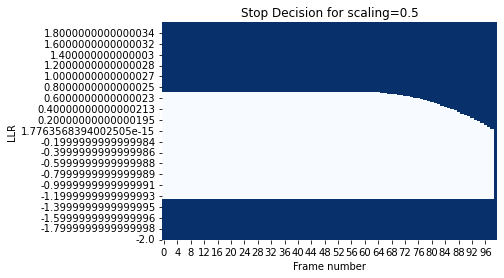

In [136]:
df = pcorrect_df
# Separate data for occluded_rows 2 and 6
df_occluded_1 = df[df['scaling'] == 1]
df_occluded_085 = df[df['scaling'] == 0.85]
df_occluded_07 = df[df['scaling'] == 0.7]
df_occluded_05 = df[df['scaling'] == 0.5]

# Function to create heatmap
def create_heatmap(df, title):
    pivot_table = df.pivot("LLR", "frame","stop_decision")
    ax=sns.heatmap(pivot_table, cmap="Blues", cbar=False)
    ax.invert_yaxis()  # Reverse the y-axis
    plt.title(title)
    plt.xlabel("Frame number")
    plt.ylabel("LLR")
    plt.show()

# Create heatmaps
create_heatmap(df_occluded_1, "Stop Decision for scaling=1")
create_heatmap(df_occluded_085, "Stop Decision for scaling=0.85")
create_heatmap(df_occluded_07, "Stop Decision for scaling=0.7")
create_heatmap(df_occluded_05, "Stop Decision for scaling=0.5")



Simulate the decision-making process

In [137]:
def run_trial(present,scaling, scaling_mapping):
    
    ## scaling mapping is a mapping from the scaling factor
    ## to participants' beliefs about the scaling factor
    
    decision = np.nan
    frame = 0
    LLR = 0
    
    while np.isnan(decision):
        
        evidence = sample_evidence(present,scaling)
        LLR += log_likelihood_ratio(evidence,scaling_mapping[scaling])
        # Find index of closest value
        index_of_closest = np.argmin(np.abs(np.array(considered_range) - LLR))
        # Get the closest value
        closest_value = considered_range[index_of_closest]
        relevant_row = pcorrect_df[(pcorrect_df['frame']==0) & (pcorrect_df['scaling']==scaling_mapping[scaling]) & 
                                   (pcorrect_df['LLR']==closest_value)].iloc[0]
        
        if relevant_row.stop_decision==1:
            if relevant_row.posterior_present>relevant_row.posterior_absent:
                decision=1
            else:
                decision=0
        frame += 1
                
    for _ in range(2):
        evidence = sample_evidence(present, scaling)
        LLR += log_likelihood_ratio(evidence, scaling_mapping[scaling])
    if relevant_row.stop_decision==1:
        if decision==1:
            confidence = np.exp(LLR)/(1+np.exp(LLR))
        else:
            confidence = 1/(1+np.exp(LLR))

        
    return((decision,frame,confidence))



In [202]:
scaling_mapping_accurate = {1:1, 0.7:0.7}
scaling_mapping_fault1 = {1:0.85, 0.7:0.85}
scaling_mapping_fault2 = {1:1, 0.7:0.5}

run_trial(0,1,scaling_mapping_fault2)

(1, 38, 0.7277790315281611)

In [204]:
simulated_trials_accurate_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence'])

num_trials = 1000

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence) = run_trial(target_present,scaling, scaling_mapping_accurate)
            simulated_trials_df.loc[len(simulated_trials_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence]
            
simulated_trials_df.to_csv('simulated_data/accum_bernoulli_occlusion.csv', index=False)


## Faulty agent 1

the first metacognitive fault is one where beliefs about stimulus visibility are the same for the two occlusion levels (scaling=0.85 for both).

In [ ]:
simulated_trials_fault1_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence'])

num_trials = 1000

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence) = run_trial(target_present,scaling, scaling_mapping_fault1)
            simulated_trials_fault1_df.loc[len(simulated_trials_fault1_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence]
            
simulated_trials_fault1_df.to_csv('simulated_data/accum_bernoulli_occlusion_fault1.csv', index=False)

## Faulty agent 2

The second metacognitive fault is one where beliefs about the effects of occlusion on visibility are exaggerated: participants overestimate the effect of high occlusion to be a scaling of 0.5, rather than 0.7 as it really is.

In [209]:
simulated_trials_fault2_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence'])

num_trials = 1000

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence) = run_trial(target_present,scaling, scaling_mapping_fault2)
            simulated_trials_fault1_df.loc[len(simulated_trials_fault2_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence]
            
simulated_trials_fault2_df.to_csv('simulated_data/accum_bernoulli_occlusion_fault2.csv', index=False)